# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: Apr 16 (Tuesday) 11:00 pm </font>  

<font color="blue"> Atefeh Mahdavi </font>

# I. Overview

This assignment is focused on blackjack which is a famous cards game. "The reinforcement learning resembles huuman learning or animal training that treats reward good behavior. When the series of actions end up with good results, we can reinforce those actions by giving some rewards [1]."

First section is the method section in which I will review Q learning and Sarsa algorithm. Then I will go over the choice of TD learning and my resaon. I will also implement the agent to play the game and explain the code.

The second section is dealing with the results and finding the best parameters. Also I will include graphs to visualize the relation of parameters with each other, accuracy and rewards. 


# II. Problems 



## Blackjack

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Blackjack_game_1.JPG" width=800 />

Now, we play Blackjack! 
We have improved version of it from OpenAI Gym [Blackjack-V0](https://gym.openai.com/envs/Blackjack-v0/). Our blackjack has an additional betting option. Here follows the rule description. 


### <font color="red"> Game Introduction and Rules: </font>


Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.

Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).

The game starts with each player getting two face up cards and dealer
having one face up and face down card and the player needs to bet an 
amount of money within range of 1 to max bet (10). 
Note: Face up means that you will know what the card is.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater (fixed policy).  If the dealer goes bust the player wins.
You won't see the dealer's facedown card, just you will know if you have or lost
and you will get appropriate reward of +1 if you win, -1 if you loose or 0 if the match
is drawn.
(It is freedom of choice for you to change the reward function. If you want to change, you should explain the reason of the change.)

If the player wins, the amount he has bet will be doubled and given back. 
If the player and dealer have the same sum, then its a draw and the player will get
back the money he has bet. 
If the player loses then, the money he bet will be lost. 
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21. You are free to change the reward function to make it 
learn more efficiently. (i.e.,  the amount of money the user is winning after each round). 

Regardless of the number of players on the table, each player will be just playing against the 
dealer independently of the other players.

## BlackJack Environment

In [1]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
import random
%matplotlib inline

### Player class definition

Player class defines an object for each BlackJack player with a given *unique* name. It has three attributes, the player's name, current cards in hand, and total balance left to play games.  <code>get_info()</code> is getter method that prints out all three attributes.

In [3]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10):
        self.player_name = player_name
        self.card = []
        self.starter_balance = start_balance
        self.total_balance = start_balance

    def recharge_account(self):
        self.total_balance = self.starter_balance
        
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))     

Following functions are utilities and definition of card deck to play games and to check the game status. 

In [4]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

### Game Environment

The Blackjack game environment is defined as follows. Inheriting, OpenAI.Gym.Env, it overrides the interfances to enable the interfaction with the same interfaces with other OpenAI Gym environments. 

These are important member functions to be used by you:
1. add_player: You can add your player object with some initial amount of money

2. step: you need to send the action using this function, actions are hit(1) or stand(0)
        returns {'state': player info and dealer info (_get_obs), 
                 'reward': real-valued reward, 
                 'is_round_done': True/Fasle}
3. _get_obs: returns the state of the env or required information you can use to build your agent. 
             eg: {'player_info':{'player_sum_card': sum of cards, 
                                 'player_card': list of cards, 
                                 'player_total_balance': real-valued number, 
                                 'usable_ace' : True/False}, 
                 'dealer_info': dealer's first card}
4. init_round: will start a new round in the same game.
        returns {'state': player info and dealer info (_get_obs)}
          
5. reset: will reset the whole game and you will being again with the initial balance you had started the player object.
        returns nothing, will just reset the entire game.
          
6. bet_money: you can bet the amount using this method, takes in the money between (1, max_bet_cap). max_bet_cap is 10. 
        returns nothing.


In [5]:


class BlackjackEnv(gym.Env):
    """
    Simple blackjack environment
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation is: the players current sum, players current card, players balance left, 
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    Parameters
    ==========
    natural      boolean
                 option for 50% more reward on natural blackjack 
    
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.total_players = 1
        self.players = {}
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        self.max_bet_cap = 10

    def add_player(self, player_class):
        if player_class not in self.players and len(self.players) < self.total_players:
            self.players[player_class.player_name] = player_class
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.players)))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, player_name, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.players[player_name].card.append(draw_card(self.np_random))
            if is_bust(self.players[player_name].card):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.players[player_name].card), score(self.dealer))
            if self.natural and is_natural(self.players[player_name].card) and reward == 1:
                reward = 1.5
        if done:
            self.settle_balance(int(reward), player_name)
        return {'state':self._get_obs(player_name), 'reward': reward, 'is_round_done': done}

    def _get_obs(self, player_name):
        return {'player_info':self.get_player_obs(player_name), 
                'dealer_info': self.dealer[0]}

    def get_player_obs(self, player_name):
        return {'player_sum_card':sum_hand(self.players[player_name].card), 
                'player_card':self.players[player_name].card, 
                'player_total_balance':self.players[player_name].total_balance, 
                'usable_ace' : usable_ace(self.players[player_name].card)}
    
    def get_valid_bet_amount(self, player_name):
        print("player name: {} money left: {}".format(player_name, self.players[player_name].total_balance))
        if self.players[player_name].total_balance < 1:
            return {'is_round_done': True, 'valid_bet_amount': -1}
        max_bet_upper_limit = self.players[player_name].total_balance
        if self.players[player_name].total_balance >= self.max_bet_cap:
            max_bet_upper_limit = self.max_bet_cap            
        return {'is_round_done': False, 'valid_bet_amount': list(range(1, max_bet_upper_limit+1))}
            
    def init_round(self, player_name):         
        self.dealer = draw_hand(self.np_random)
        self.players[player_name].card = draw_hand(self.np_random)
        return {'state': self._get_obs(player_name)}        

    def bet_money(self, player_name, bet_amount):
        self.players[player_name].total_balance -= bet_amount
        self.round_bet_info[player_name] = bet_amount
            
    def settle_balance(self, is_winner, player_name):
        if is_winner == 1:
            print("player winner")
            self.players[player_name].total_balance += (2 * self.round_bet_info[player_name])
        elif is_winner == 0:
            print("Draw match")
            self.players[player_name].total_balance += self.round_bet_info[player_name]
        else:
            print("player loser, wont get back the money, try next round")
    
    def reset(self, natural=False):
        for player_name, player_class in self.players.items():
            player_class.recharge_account()
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}


### Example Run with Random Players

This following code shows how to create an environment and players to play 10 games with 20 maximum rounds. This only includes random betting and random hit/stick decision making. 

In [6]:
env = BlackjackEnv()
player1 = Player('player1')
env.add_player(player1)
#Number of games
number_of_games = 10

#Number of rounds
number_of_rounds = 20

for _game in range(number_of_games):

    env.reset()
    print("-"* 50)
    print("Game Number: {}".format(_game + 1))
    print("-"* 50)
    for _round in range(number_of_rounds): 
        print("%"* 50)
        print("Game Number: {} Round Number: {}".format(_game+1, _round+1))
        print("%"* 50)
        
        #Check if you have enough money left in the account to bet, if not break and start a new game
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
            print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']
        
        #Get the observations i.e state and use it to decide how much you want to bet
        round_obs = env.init_round(player1.player_name)
        print("Initial state: {}".format(round_obs))  
        
        # If you have just $1 left in the bank, you have no choice but to bet that amount 
        # and hopefully leave it to the fate for your agent to win and continue playing or just
        # start a new game
        if len(bet_amount) == 1 and bet_amount[0] == 1:
            print("You can only bet 1. So betting only 1.")
            random_bet = 1
        else:
            random_bet = np.random.choice(bet_amount)
        print("Random Init Bet: {}".format(random_bet))
        env.bet_money(player1.player_name, random_bet)
          
        
        # Look at the state and take actions, here the actions are selected randomly
        # you can use the agent to select the action
        random_action = np.random.randint(0, 2)
        print("Action taken: {}".format(random_action))

        #Use the selected action to actually take the action in env by calling step
        round_obs = env.step(player1.player_name, random_action)
        print("State after 1st action: {}".format(round_obs))

        #Check if the game is not over, if your action is stand then the game is over, else
        #the game continues in this loop until your action is stand
        while not round_obs['is_round_done']:
            #Select an random action and take the action
            random_action = np.random.randint(0, 2)
            print("Action taken: {}".format(random_action))
            round_obs = env.step(player1.player_name, random_action)
            print("State after nth action: {}".format(round_obs))

        #Round over, but the game will continue untill you have exhausted your initial money 
        print("Balance Left: {}".format(round_obs['state']['player_info']['player_total_balance']))
        print("Round over")
        print("-%-"*30)
        if (_round + 1) == (number_of_rounds):
            print("Max number of rounds played. If you see this message, you are the winner.")

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [10, 9], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 7}}
Random Init Bet: 8
Action taken: 0
player winner
State after 1st action: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [10, 9], 'player_total_balance': 18, 'usable_ace': False}, 'dealer_info': 7}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 18
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 18
Initial state:

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Decide your function approximator.
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

### Review of the SARSA and Q-Learning

From reference [1]

For control problems, we have defined Q function above to evaluate the state and action altogether. Updating the Q values with TD learning is similar to previous update with two different considerations. First, we update the Q with assumption that we follow a certain behavior policy. Thus, we call this as on-policy control, or SARSA.

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

Next, without making assumption of behavior policy, we can explore other possible policies to update the Q. We call this as *off-policy control*, or **Q-learning**. 


$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

Each algorithm is presented here:

Here describes the psedocode for each algorithm. 


**[Algorithm: TD Learning]**
![](http://incompleteideas.net/book/ebook/pseudotmp7.png)

**[Algorithm: SARSA]**
![](http://incompleteideas.net/book/ebook/pseudotmp8.png)


**[Algorithm: Q-learning]**
![](http://incompleteideas.net/book/ebook/pseudotmp9.png)

### Choice of TD learning and Reason

For my implementation I choose Q-learning algorithm because it is not dependent on policy and is able to find the optimal action without independently from policy. Also the number of possible states are small. 

###  Choice of Function Approximation and Reason

Q-learning can be combined with function approximation. This makes it possible to apply the algorithm to larger problems, even when the state space is continuous [2]. In the epsilon_greed function I use a Q table to let the agent choose an action. 



## RLAgent for Blackjack

#### Implementation of the selected approach (RLAgent)

For implementing the Q-learning I used the epsilon_greed function to let the agent choose its next action based on the highest Q value. The first round is initialized and for the next iterations the action will be selected based on the epsilon greedy function. The sigma value in the epsilon_greed option determines how much exploration is allowed by the agent. It is usually a very small value to allow some degree of randomness with probability epsilon. The alpha (learning rate) rate is the speed with which agent learns. gamma(discount factor) is determines how important are the future actions. 

**[Q-learning implementation]** [2]
![title](1.png "Title")

The steps for implementation are [3]:

Step 1: initialize the Q-Table

Steps 2 : choose and perform an action

Steps 4 : evaluate

### Explanation of the code

The RLAgent class has four methods, _init_, epsilon_greed, train and test. 
The init constructor takes care of the initializes which are environment for train and test and q table and a list for actions (hit(1) or stand(0)).

The epsilon_greed function returns an action with maximum value if the random number is greater than epsilon otherwise it randomly chose and action between the two choices. The train function has the parameters and it iterates by the number of rounds and number of steps. It also takes care of random betting and checking the state of the environment to see whether the money left is 1 or more and also if the agent is busted. The Q table is updated based on the state and actions by using the Q learning formula.
The test method creates a new environment and agent and using the Q table plays the game for 100 rounds. 


In [119]:
class RLAgent: 
    
    def __init__(self, evn):
        self.choice = [0,1]
        # self.Q table including the surrounding border
        self.Q = np.random.rand(32, 11, 2, 2)
        self.env = BlackjackEnv()
        self.test_env = BlackjackEnv()

    def epsilon_greed(self, epsilon, s, env):
        if np.random.rand() < epsilon:
            return random.choice(self.choice)
        else:
            flag = True
            choice = self.Q[s[0]][s[1]][s[2]] 
            while flag:
                if np.argmax(choice) in self.choice:
                    action = np.argmax(choice)     
                    flag = False
                else:
                    choice = np.delete(x,np.argmax(choice))   
                    flag = True
                return action
    
    def train(self, start, **params):
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        self.epsilon= params.pop('epsilon', 0.1)
        #Number of games
        maxiter= params.pop('maxiter', 1000) 
        #Number of rounds
        maxstep= params.pop('maxstep', 1000)
        
        
        rtrace = []
        steps = []
        
        player1 = Player('player1')
        self.env.add_player(player1)
        for _game in range(maxiter):
            rewards = []
            self.env.reset()
            self.env.init_round(player1.player_name)
            print("-"* 50)
            print("Game Number: {}".format(_game + 1))
            print("-"* 50)
            for _round in range(maxstep):
                print("%"* 50)
                print("Game Number: {} Round Number: {}".format(_game+1, _round+1))
                print("%"* 50)
                self.env.init_round(player1.player_name)
                valid_bet_flag = self.env.get_valid_bet_amount(player1.player_name)
                if valid_bet_flag['is_round_done']:
                    print("You are out of money ! Will go to next game !!")
                    break
                bet_amount = valid_bet_flag['valid_bet_amount']

                # If you have just $1 left in the bank, you have no choice but to bet that amount 
                # and hopefully leave it to the fate for your agent to win and continue playing or just
                # start a new game
                if len(bet_amount) == 1 and bet_amount[0] == 1:
                    print("You can only bet 1. So betting only 1.")
                    random_bet = 1
                else:
                    random_bet = np.random.choice(bet_amount)
                    
                print("Random Init Bet: {}".format(random_bet))
                self.env.bet_money(player1.player_name, random_bet)
                s = self.env._get_obs(player1.player_name)
#                 print('s',s)
                state = np.array([int(s['player_info']['player_sum_card']), int(s['dealer_info']), int(s['player_info']['usable_ace'])])
                a = self.epsilon_greed(self.epsilon, state, self.env)
                step1 = self.env.step("player1", a)
                isdone = step1['is_round_done']
                
                
                if step1['is_round_done']:
                    current_balance = self.env.get_player_obs(player1.player_name)['player_total_balance']
                    print(current_balance)
                    s = self.env._get_obs(player1.player_name)
                    state1 = np.array([int(s['player_info']['player_sum_card']), int(s['dealer_info']), int(s['player_info']['usable_ace'])])
                     
                    r = int(step1['reward'])
                    rewards.append(r)
                    self.Q[state[0]][state[1]][state[2]][a] = self.Q[state[0]][state[1]][state[2]][a]+alpha*(r+(gamma*max(self.Q[state1[0]][state1[1]][state1[2]]))-self.Q[state[0]][state[1]][state[2]][a])
                    continue
                    
                while not step1['is_round_done']:
                    current_balance = self.env.get_player_obs(player1.player_name)['player_total_balance']
                    s = self.env._get_obs(player1.player_name)
#                     print('s',s)
                    state = np.array([int(s['player_info']['player_sum_card']), int(s['dealer_info']), int(s['player_info']['usable_ace'])])
                    a = self.epsilon_greed(self.epsilon, state, self.env)
                    step1 = self.env.step("player1", a)
                    isdone = step1['is_round_done']
                    r = int(step1['reward'])
                    s = self.env._get_obs(player1.player_name)
                    state1 = np.array([int(s['player_info']['player_sum_card']), int(s['dealer_info']), int(s['player_info']['usable_ace'])])
                    a1 = self.epsilon_greed(self.epsilon, state1, self.env)
                #Round over, but the game will continue untill you have exhausted your initial money 
                print("Balance Left: {}".format(current_balance))
                print("Round over")
                print("-%-"*30)    
                rewards.append(r)               
                self.Q[state[0]][state[1]][state[2]][a] = self.Q[state[0]][state[1]][state[2]][a]+alpha * (r+(gamma*max(self.Q[state1[0]][state1[1]][state1[2]]))-self.Q[state[0]][state[1]][state[2]][a])
                continue
            rtrace.append(np.sum(rewards))
        return rtrace,self.Q
        

    def test(self):       
        win = 0
        loss = 0
        #Number of rounds
        maxstep = 1000
        ptest = Player('player1')
        self.test_env.add_player(ptest)
        for i in range(100):
            self.test_env.reset()
            for j in  range(maxstep):
                self.test_env.init_round(ptest.player_name)
    
                # from class notebook
                valid_bet_flag = self.test_env.get_valid_bet_amount(ptest.player_name)
                if valid_bet_flag['is_round_done']:
                    print("You are out of money ! Will go to next game !!")
                    break
                bet_amount = valid_bet_flag['valid_bet_amount']

                # If you have just $1 left in the bank, you have no choice but to bet that amount 
                # and hopefully leave it to the fate for your agent to win and continue playing or just
                # start a new game
                if len(bet_amount) == 1 and bet_amount[0] == 1:
                    print("You can only bet 1. So betting only 1.")
                    random_bet = 1
                else:
                    random_bet = np.random.choice(bet_amount)
                    
                print("Random Init Bet: {}".format(random_bet))
                self.test_env.bet_money(ptest.player_name, random_bet)
                s = self.test_env._get_obs(ptest.player_name)
                state = np.array([int(s['player_info']['player_sum_card']), int(s['dealer_info']), int(s['player_info']['usable_ace'])])
                a = self.epsilon_greed(self.epsilon, state, self.test_env)
                step1 = self.test_env.step("player1", a)
                isdone = step1['is_round_done']
                current_balance = self.test_env.get_player_obs(ptest.player_name)['player_total_balance']
                r = step1['reward']
                if r>0:
                    win += 1
                elif r<0:
                    loss += 1
                while not step1['is_round_done']:
                    current_balance = self.test_env.get_player_obs(ptest.player_name)['player_total_balance']
#                     print(current_balance)
                    s = self.test_env._get_obs(ptest.player_name)
                    state = np.array([int(s['player_info']['player_sum_card']), int(s['dealer_info']), int(s['player_info']['usable_ace'])])
                    a = self.epsilon_greed(self.epsilon, state, self.test_env)
                    step1 = self.test_env.step("player1", a)
                    r = int(step1['reward'])
                    if r>0:
                        win += 1
                    elif r<0:
                        loss += 1
                    
                    print("result: {}".format(step1))
                #Round over, but the game will continue untill you have exhausted your initial money 
                print("Balance Left: {}".format(current_balance))
                print("Round over")
                print("-%-"*30)
        
        return win,loss
                
    

### Train the agent 

In [120]:
env=BlackjackEnv()
agent = RLAgent(env)
start = [0,0]
rtrace, Q = agent.train(start,gamma=0.99,alpha=0.1,epsilon=0.1,maxiter=100,maxstep=1000)

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Random Init Bet: 3
player loser, wont get back the money, try next round
Balance Left: 7
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 7
Random Init Bet: 6
player loser, wont get back the money, try next round
1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
You can only bet 1. So betting only 1.
Random Init Bet: 1
player winner
2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Balance Left: 0
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 21 Round Number: 7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 21 Round Number: 8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 0
You are out of money ! Will go to next game !!
--------------------------------------------------
Game Number: 22
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 22 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Random Init Bet: 4
player loser, wont get back the money, try next round
6
%%%%%%%%%%%%%%%%%%%%

Draw match
7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 51 Round Number: 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 7
Random Init Bet: 5
player loser, wont get back the money, try next round
2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 51 Round Number: 6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 2
Random Init Bet: 1
player loser, wont get back the money, try next round
1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 51 Round Number: 7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 51 Round Number: 8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 0
You are out of money ! Will go to next game !!


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 77 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 7
Random Init Bet: 3
Draw match
7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 77 Round Number: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 7
Random Init Bet: 4
player loser, wont get back the money, try next round
3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 77 Round Number: 4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 3
Random Init Bet: 1
Draw match
Balance Left: 2
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 77 Round Number: 5
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 3
Random Init Bet: 3
player loser, wont get back the money, try next ro

Game Number: 98
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 98 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Random Init Bet: 9
player loser, wont get back the money, try next round
Balance Left: 1
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 98 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
Balance Left: 0
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 98 Round Number: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 0
You 

### Test method and calculating the accuracy
Caculate the accuracy based on the percentage of the wins and losses.

In [121]:
win,loss = agent.test()
total = win+loss
accuracy = (win/total)*100
print("accuracy" + str(accuracy))

player name: player1 money left: 10
Random Init Bet: 4
player loser, wont get back the money, try next round
result: {'state': {'player_info': {'player_sum_card': 16, 'player_card': [7, 5, 4], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 6
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 6
Random Init Bet: 1
player winner
result: {'state': {'player_info': {'player_sum_card': 19, 'player_card': [1, 1, 7], 'player_total_balance': 7, 'usable_ace': True}, 'dealer_info': 10}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 5
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 7
Random Init Bet: 6
result: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [2, 7, 5, 7], 'player_total_balance': 1, 'usable_ace': False}, 'dealer_info': 

Balance Left: 2
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 2
Random Init Bet: 2
player loser, wont get back the money, try next round
Balance Left: 0
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 0
You are out of money ! Will go to next game !!
player name: player1 money left: 10
Random Init Bet: 3
player loser, wont get back the money, try next round
Balance Left: 7
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 7
Random Init Bet: 5
player loser, wont get back the money, try next round
result: {'state': {'player_info': {'player_sum_card': 31, 'player_card': [4, 7, 10, 10], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 7}, 'reward': -1, 'is_round_done': True}
Balance Left: 2
Round over
-%--%--%--%--%--%-

-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 3
Random Init Bet: 3
player loser, wont get back the money, try next round
Balance Left: 0
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 0
You are out of money ! Will go to next game !!
player name: player1 money left: 10
Random Init Bet: 5
player winner
Balance Left: 15
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 15
Random Init Bet: 8
player loser, wont get back the money, try next round
result: {'state': {'player_info': {'player_sum_card': 15, 'player_card': [1, 4, 10], 'player_total_balance': 7, 'usable_ace': False}, 'dealer_info': 8}, 'reward': -1.0, 'is_round_done': True}
Balance Left: 7
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--

player name: player1 money left: 9
Random Init Bet: 9
player winner
result: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [10, 3, 8], 'player_total_balance': 18, 'usable_ace': False}, 'dealer_info': 10}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 0
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 18
Random Init Bet: 1
player winner
Balance Left: 19
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 19
Random Init Bet: 6
player loser, wont get back the money, try next round
Balance Left: 13
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 13
Random Init Bet: 5
player loser, wont get back the money, try next round
result: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [5, 2, 10], 'player_tot

result: {'state': {'player_info': {'player_sum_card': 16, 'player_card': [2, 3, 10, 1], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 2}, 'reward': 0, 'is_round_done': False}
result: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [2, 3, 10, 1, 5], 'player_total_balance': 2, 'usable_ace': False}, 'dealer_info': 2}, 'reward': 0, 'is_round_done': False}
player winner
result: {'state': {'player_info': {'player_sum_card': 21, 'player_card': [2, 3, 10, 1, 5], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 2}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 2
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 6
Random Init Bet: 5
player winner
Balance Left: 11
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
player name: player1 money left: 11
Random Init Bet: 9
player loser, wont get back the money, t

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

### Change alpha value


In [14]:
%%capture
alphalist = [0.001, 0.01,0.1,1]
a =[]

for i in range(4):
    env=BlackjackEnv()
    agent = RLAgent(env)
    start = [0,0]
    alphaValue=alphalist[i]
    agent.train(start,gamma=0.99,alpha=alphaValue,epsilon=0.1,maxiter=1000,maxstep=1000)
    win,loss = agent.test()
    total = win+loss
    accuracy = (win/total)*100
    a.append(accuracy)
# plt.plot(a,alphalist)
# plt.ylabel("# steps")

alpha=0.001   accuracy = 32.86118980169972
alpha=0.01   accuracy = 35.21303258145363
alpha=0.1   accuracy = 36.57635467980296
alpha=1   accuracy = 40.93778178539225


Text(0.5, 0, 'alpha')

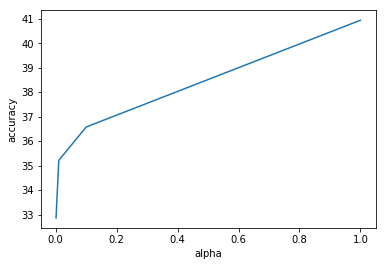

In [15]:
for i in range(4):
    print("alpha="+ str(alphalist[i])+"   accuracy = " + str(a[i]))
    
plt.plot(alphalist, a)
plt.ylabel("accuracy")
plt.xlabel("alpha")

The learning rate or step size determines to what extent newly acquired information overrides old information. A factor of 0 makes the agent learn nothing (exclusively exploiting prior knowledge), while a factor of 1 makes the agent consider only the most recent information (ignoring prior knowledge to explore possibilities) [2] 
 
As the above graph shows as the alpha value increases we get a higher accuracy which means in this case as the agent is only considering the most recent actions it performs better. 

### Change gamma value

In [16]:
%%capture
gammalist = [0.2, 0.4,0.8,2]
g =[]

for i in range(4):
    env=BlackjackEnv()
    agent = RLAgent(env)
    start = [0,0]
    alphaValue=alphalist[i]
    agent.train(start,gamma=gammalist[i],alpha= 1,epsilon=0.1,maxiter=1000,maxstep=1000)
    win,loss = agent.test()
    total = win+loss
    accuracy = (win/total)*100
    g.append(accuracy)
# plt.plot(a,alphalist)
# plt.ylabel("# steps")

gamma=0.2   accuracy = 29.28082191780822
gamma=0.4   accuracy = 26.39593908629442
gamma=0.8   accuracy = 32.5
gamma=2   accuracy = 35.1123595505618


Text(0.5, 0, 'gamma')

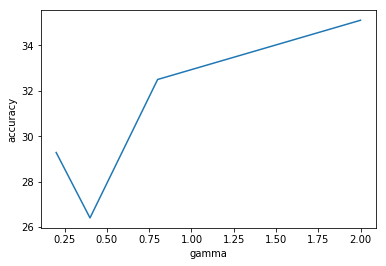

In [17]:
for i in range(4):
    print("gamma="+ str(gammalist[i])+"   accuracy = " + str(g[i]))
    
plt.plot(gammalist, g)
plt.ylabel("accuracy")
plt.xlabel("gamma")

Change of the gamma value has fluctuations. Before 0.5 it is decreaseing but after that it starts to increase .At the gamma= 2 accuracy has the highest value and at gamma=0.4 it is the lowest. The lower the gamma value the more short-sighted the agent becomes. 

### Change epsilon value

In [20]:
%%capture
epsilonlist = [0.02, 0.05,0.07,0.1]
e =[]

for i in range(4):
    env=BlackjackEnv()
    agent = RLAgent(env)
    start = [0,0]
    alphaValue=alphalist[i]
    agent.train(start,gamma=2,alpha= 1,epsilon=epsilonlist[i],maxiter=1000,maxstep=1000)
    win,loss = agent.test()
    total = win+loss
    accuracy = (win/total)*100
    e.append(accuracy)
# plt.plot(a,alphalist)
# plt.ylabel("# steps")

epsilon=0.02   accuracy = 38.05220883534137
epsilon=0.05   accuracy = 42.46153846153846
epsilon=0.07   accuracy = 42.07149404216315
epsilon=0.1   accuracy = 42.04355108877722


Text(0.5, 0, 'epsilon')

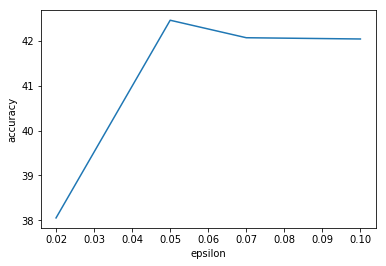

In [21]:
for i in range(4):
    print("epsilon="+ str(epsilonlist[i])+"   accuracy = " + str(e[i]))
    
plt.plot(epsilonlist, e)
plt.ylabel("accuracy")
plt.xlabel("epsilon")

The epsilon valu wich shows how random the actions can be becomes relatively stable between 0.05 and 1. However, higher values for epsilon doens't let the agent to explore enough.

# Best parameters selected from above experiments

gamma=2, alpha= 1,epsilon=0.05

In [22]:
%%capture
env=BlackjackEnv()
agent = RLAgent(env)
start = [0,0]
alphaValue=alphalist[i]
agent.train(start,gamma=2,alpha= 1,epsilon=0.05,maxiter=1000,maxstep=1000)
win,loss = agent.test()
total = win+loss
accuracy = (win/total)*100


In [23]:
print("accuracy = " + str(accuracy))

accuracy = 40.549828178694156


Here I abserved that although I selected the best parameters from above experiments, I didn't get the best accuracy in comparison to the previous accuracies. So I decided to change them all together to be able to choose the best parameters more accurately. The below experiment is showing all the possible combinations of the gamma, alpha and epsilion and the corresponding accuracies:

In [185]:
%%capture
f = []
t = []
r = []
for i in range(4):
    for j in range(4):
        for k in range(4):
            env=BlackjackEnv()
            agent = RLAgent(env)
            start = [0,0]
            rtrace, Q = agent.train(start,gamma=gammalist[i],alpha= alphalist[j],epsilon=epsilonlist[k],maxiter=100,maxstep=1000)
            win,loss = agent.test()
            total = win+loss
            accuracy = (win/total)*100
            f.append([accuracy,gammalist[i], alphalist[j],epsilonlist[k]])
            t.append(win)
            r.append([rtrace,[gammalist[i], alphalist[j],epsilonlist[k]]])
            

### Different parameters and the corresponding accuracy

There are 64 combinations. 4 for each parameter.

In [162]:
for i in range(len(f)):
    print("accuracy="+ str(f[i][0])+ "   gamma=" + str(f[i][1])+"   alpha = " + str(f[i][2]) + "  epsilon = " + str(f[i][3]))
    

accuracy=33.810888252149   gamma=0.2   alpha = 0.001  epsilon = 0.02
accuracy=35.047846889952154   gamma=0.2   alpha = 0.001  epsilon = 0.05
accuracy=28.35538752362949   gamma=0.2   alpha = 0.001  epsilon = 0.07
accuracy=28.825622775800714   gamma=0.2   alpha = 0.001  epsilon = 0.1
accuracy=31.03448275862069   gamma=0.2   alpha = 0.01  epsilon = 0.02
accuracy=29.951690821256037   gamma=0.2   alpha = 0.01  epsilon = 0.05
accuracy=33.18840579710145   gamma=0.2   alpha = 0.01  epsilon = 0.07
accuracy=27.389705882352942   gamma=0.2   alpha = 0.01  epsilon = 0.1
accuracy=37.741607324516785   gamma=0.2   alpha = 0.1  epsilon = 0.02
accuracy=43.47826086956522   gamma=0.2   alpha = 0.1  epsilon = 0.05
accuracy=37.552742616033754   gamma=0.2   alpha = 0.1  epsilon = 0.07
accuracy=39.69118982742961   gamma=0.2   alpha = 0.1  epsilon = 0.1
accuracy=30.46875   gamma=0.2   alpha = 1  epsilon = 0.02
accuracy=34.624697336561745   gamma=0.2   alpha = 1  epsilon = 0.05
accuracy=34.473684210526315   gam

### The best parameters based on the above combinations are:

accuracy=43.47826086956522   gamma=0.2   alpha = 0.1  epsilon = 0.05

### Output plots 

#### The accuracy correcpoding to different alpha, gamma and epsilon combinations

Text(0.5, 0, 'agents')

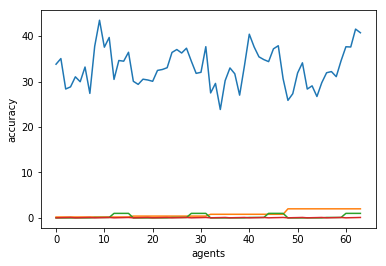

In [156]:
plt.plot(f)
plt.ylabel("accuracy")
plt.xlabel("agents (with different parameters)")

#### The number of wins per combination

Text(0.5, 0, 'agents')

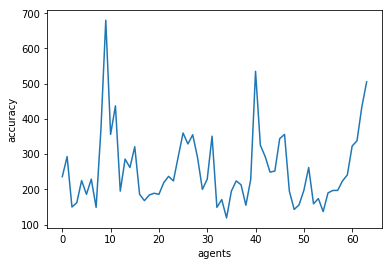

In [157]:
plt.plot(t)
plt.ylabel("wins")
plt.xlabel("agents (with different parameters)")

#### Rewards for one round of games and different parameters

gamma, alpha, epsilon [0.2, 0.001, 0.02]


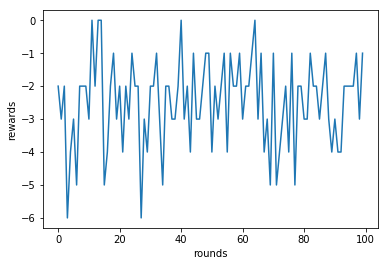

In [187]:
plt.plot(r[0][0])
plt.ylabel("rewards")
plt.xlabel("rounds")
print("gamma, alpha, epsilon", r[0][1])

#### Plots of rewards for different combinations

[gamma, alpha, epsilon]


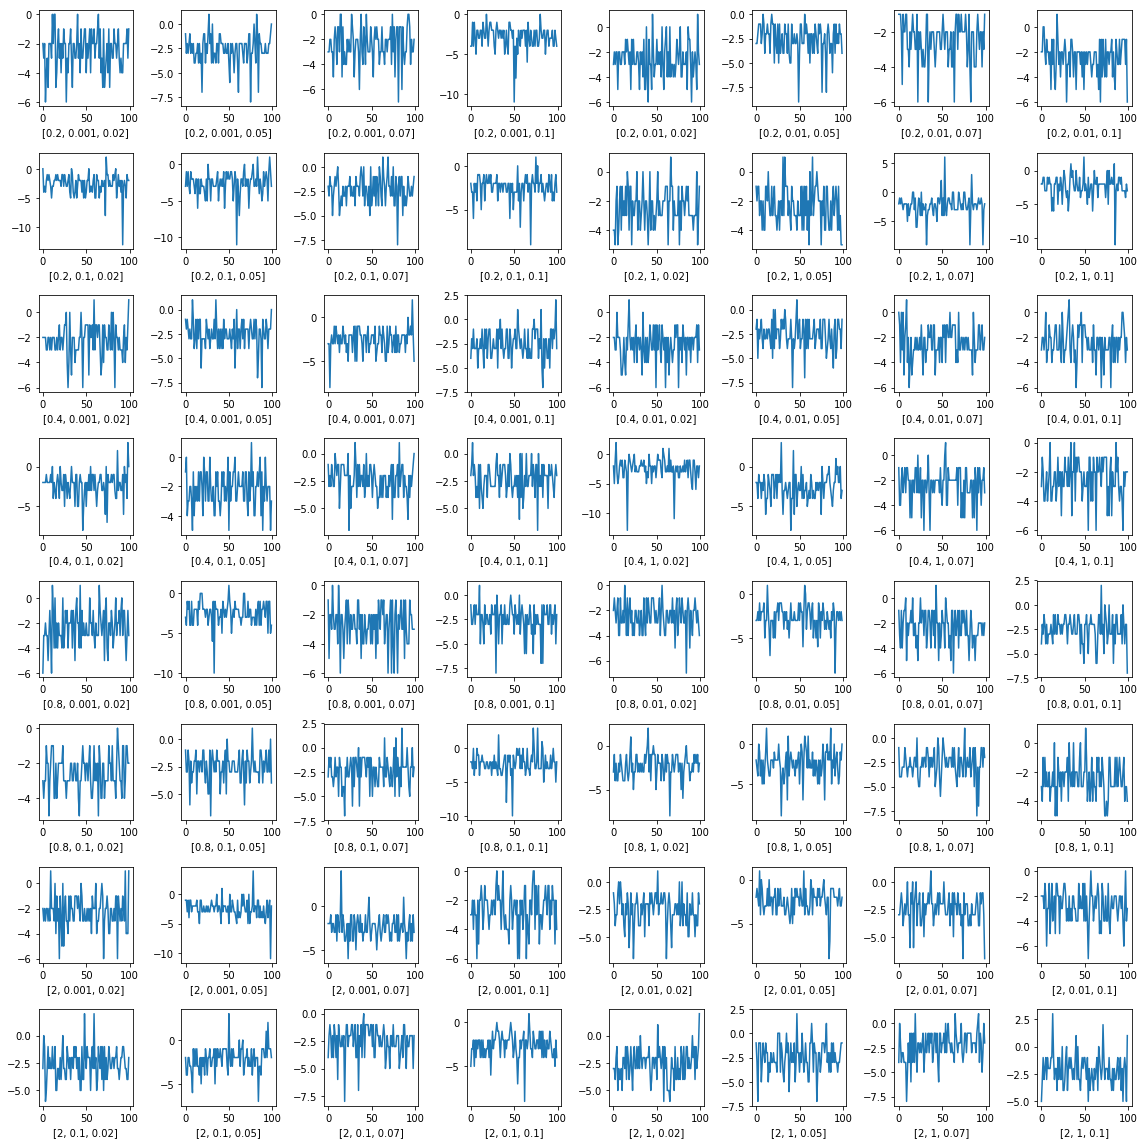

In [198]:
print("[gamma, alpha, epsilon]")
fig = plt.figure(figsize=(16,16))
plt.clf()
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.plot(r[i][0])
    plt.xlabel(str(r[i][1]))
fig.tight_layout()


In [103]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(rtrace, "b-")
    plt.ylabel("sum of rewards")

    plt.plot()

In [202]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   amma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Random Init Bet: 2
player winner
12
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 12
Random Init Bet: 8
player loser, wont get back the money, try next round
Balance Left: 4
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 4
Random Init Bet: 1
Draw match
4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Game Number: 19 Round Number: 34
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 4
Random Init Bet: 1
Draw match
4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 19 Round Number: 35
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 4
Random Init Bet: 2
player loser, wont get back the money, try next round
2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 19 Round Number: 36
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 2
Random Init Bet: 1
player winner
3
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 19 Round Number: 37
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 3
Random Init Bet: 2
player loser, wont get back the money, try next round
Balance Left: 1
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

Game Number: 43 Round Number: 6
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 2
Random Init Bet: 1
player loser, wont get back the money, try next round
1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 43 Round Number: 7
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 43 Round Number: 8
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 0
You are out of money ! Will go to next game !!
--------------------------------------------------
Game Number: 44
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 44 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Random Init Bet: 5
p

player name: player1 money left: 8
Random Init Bet: 8
player loser, wont get back the money, try next round
0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 67 Round Number: 4
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 0
You are out of money ! Will go to next game !!
--------------------------------------------------
Game Number: 68
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 68 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Random Init Bet: 4
player loser, wont get back the money, try next round
Balance Left: 6
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 68 Round Number: 2
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 6
Random Init Bet: 5
player 

player winner
Balance Left: 0
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%-
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 89 Round Number: 9
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 4
Random Init Bet: 3
player loser, wont get back the money, try next round
1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 89 Round Number: 10
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 1
You can only bet 1. So betting only 1.
Random Init Bet: 1
player loser, wont get back the money, try next round
0
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 89 Round Number: 11
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 0
You are out of money ! Will go to next game !!
--------------------------------------------------
Game Number: 90
--------------------------------------------------
%%%%%

ValueError: not enough values to unpack (expected 3, got 2)

#### Some of rewards per round for 100 rounds

Text(0, 0.5, 'sum of rewards')

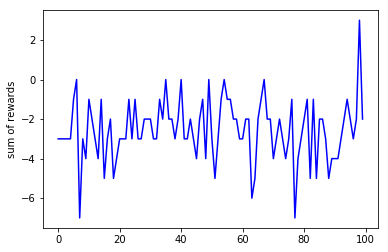

In [114]:
plt.plot(rtrace, 1000)
plt.ylabel("sum of rewards")

# V. Conclusions

In this assignment, I learned how to implement an agent instead of using random actions for the blackjack game. I think the assignment was very helpful in understanding the concepts because they became easier to understand in the context of a game. Now I think learning ML assignments in a more tangible context is better for understanding the algorithms. 

The train method in the RLAgent was the most difficult part for me because it had so many components. Also conecting the three different classes, environment, player and agent was challenging.

A next step for this assignment which I think would be helpful for winning the tournament is to do the same training process for the betting process instead of random betting.



## References

[1] class notebooks

[2] https://en.wikipedia.org/wiki/Q-learning

[3] https://medium.freecodecamp.org/an-introduction-to-q-learning-reinforcement-learning-14ac0b4493cc

# Extra Credit for Tournament Top16!

- In two classes, we will have qualification and tournament.
- In qualification game, individual will play against a dealer for one game for 50 round. 
  - Highly ranked (by the profit) and non-broke players will proceed to the tournament.
  - max. 32 players will be cut for main tournament.
- In tournament, 4 players will be play in each round.
  - In a table game, the game lasts until two players broke
  - In final, the game will ends in 50 rounds and winner will be the one with highest balance. 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
35 | Methods | 
 |10| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 | 5| Choice of Function Approximation and Reason
 |10| Implementation of the selected approach (RLAgent)
 | 5| explanation of the codes
45 | Results 
 |10| Reports the selected parameters 
 |15| Experimental outputs that show the choice of parameters. How do you choose them?
 |10| Output plots (5 for each)
 |10| reading and analysis of learning results and plots
10 | Participation to the tournament.
5 | Conclusions 
